In [442]:
import numpy as np
import networkx as nx
import skimage.io as skio
import skimage.util as sku

In [443]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

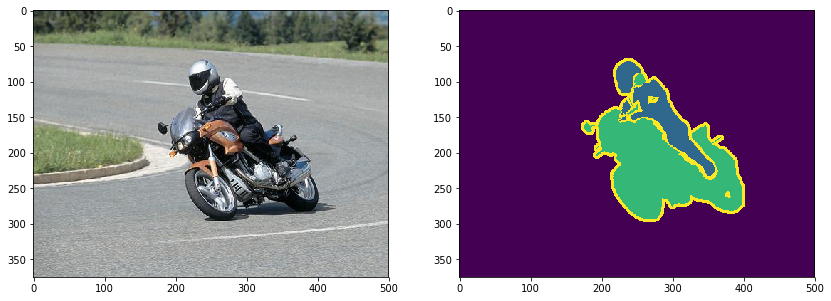

In [444]:
img = sku.img_as_float(skio.imread("moto.jpg"))

seg_orig = skio.imread("moto_seg.png")
_, true_seg = np.unique(seg_orig.reshape(-1, 3), axis=0, return_inverse=True)
true_seg = true_seg.reshape(seg_orig.shape[:2])

_, (left, right) = plt.subplots(1, 2)
right.imshow(true_seg);
left.imshow(img);

In [445]:
import skimage.segmentation as seg

In [446]:
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

In [447]:
def hufbauer_alpha(image, labels, connectivity=2):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'total brightness': 0,
                            'total pixels': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['total pixels'] += 1
        rag.node[current]['total brightness'] += np.sqrt(np.dot(image[index], image[index])) / np.sqrt(3)
        if rag.node[current]['total brightness'] > rag.node[current]['total pixels']:
            print(np.sqrt(np.dot(image[index], image[index])) / np.sqrt(3))
    
    for n in rag:
        rag.node[n]['total brightness'] /= rag.node[n]['total pixels']

    for x, y, d in rag.edges(data=True):
        d['weight'] = 2 / (1 + np.abs(rag.node[x]['total brightness'] - rag.node[y]['total brightness'])) - 1
#         if d['weight'] < 0.6:
#             d['weight'] = 0

    return rag

In [448]:
def hufbauer_beta(image, labels, connectivity=2):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'total brightness': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        color = image[index] - [0.5, 0.5, 0.5]
        rag.node[current]['total brightness'] += np.sqrt(np.dot(color, color))
        rag.node[current]['total color'] += color

    for n in rag:
        rag.node[n]['total color'] *= 1.0 / rag.node[n]['total brightness']

    for x, y, d in rag.edges(data=True):
        d['weight'] = (1 + np.dot(rag.node[x]['total color'], rag.node[y]['total color'])) / 2
#         if d['weight'] < 0.6:
#             d['weight'] = 0

    return rag

In [449]:
def rag_val(g):
    values = []
    for _, _, d in g.edges(data=True):
        values.append(d["weight"])
    return values

In [450]:
sps = seg.slic(img, slic_zero=True)
rag_a = hufbauer_alpha(img, sps)
rag_b = hufbauer_beta(img, sps)

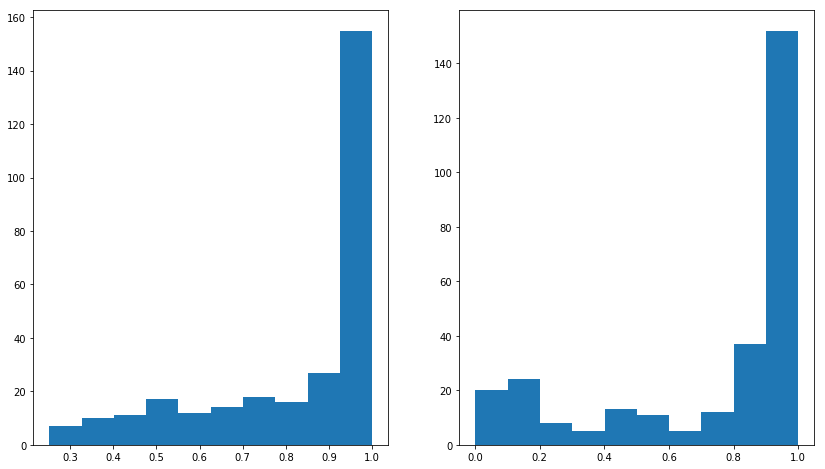

In [451]:
_, (l, r) = plt.subplots(1, 2)
l.hist(rag_val(rag_a))
r.hist(rag_val(rag_b))
plt.show()

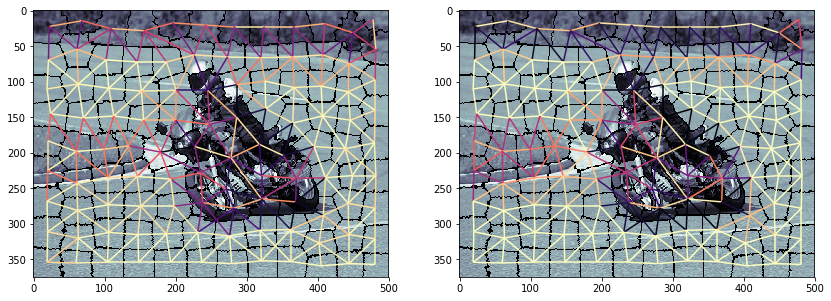

In [452]:
_, (l, r) = plt.subplots(1, 2)
graph.show_rag(sps, rag_a, img, ax=l)
graph.show_rag(sps, rag_b, img, ax=r)

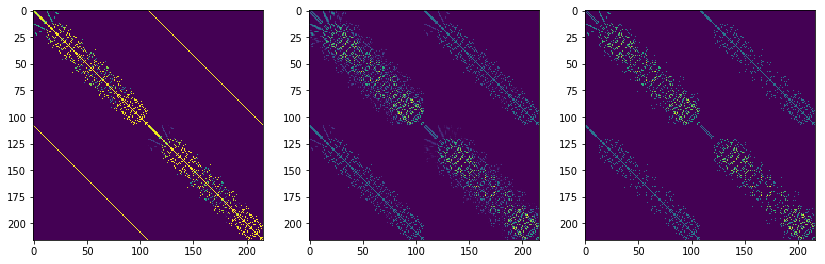

In [488]:
sps = seg.slic(img, slic_zero=True)
num_sps = sps.max() + 1

adj_a = nx.adjacency_matrix(rag_a).todense()
adj_b = nx.adjacency_matrix(rag_b).todense()

adj = np.c_[
    np.r_[
        adj_a, 
        np.diag(np.ones(num_sps)),
    ],
    np.r_[
        np.diag(np.ones(num_sps)),
        adj_b,
    ],
]
np.fill_diagonal(adj, 1)
_, (l, m, r) = plt.subplots(1, 3)
l.imshow(adj)
adj = adj ** 2
np.fill_diagonal(adj, 0)
m.imshow(adj)
adj[adj < np.percentile(adj[adj > 0], 50)] = 0
r.imshow(adj)

In [605]:
import dynSIS
import importlib
importlib.reload(dynSIS)

<module 'dynSIS' from '/Users/emory/Desktop/587/image_seg_interdep_epidemic/src/notebooks/dynSIS.py'>

In [612]:
# Run it through the simulator
proposals = dynSIS.dyn_run(nx.Graph(adj), samples=108, run_time=30, init=1)
# Extract the data
proposals = np.array([np.fromiter(prop.values(), dtype=float) for prop in proposals]).T
# Fold the two layers together
proposals = sum(np.array(np.split(proposals, 2)), 0).T

In [613]:
list(proposals)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 0., 2., 1.,
       2., 0., 1., 1., 1., 1., 2., 0., 0., 0., 1., 2., 4., 0., 2., 2., 2.,
       0., 2., 2., 0., 0., 0., 0., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

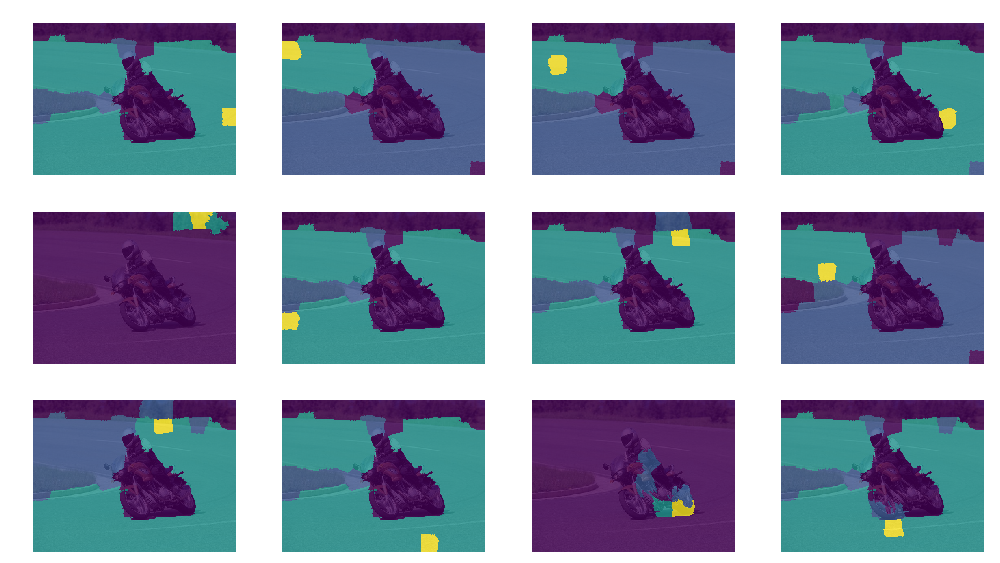

In [614]:
_, axs = plt.subplots(3,4)
for bar, ax in zip(proposals, axs.flat):
    ax.matshow(bar[sps])
    ax.imshow(img, alpha=0.2)
    ax.set_axis_off()
plt.tight_layout();

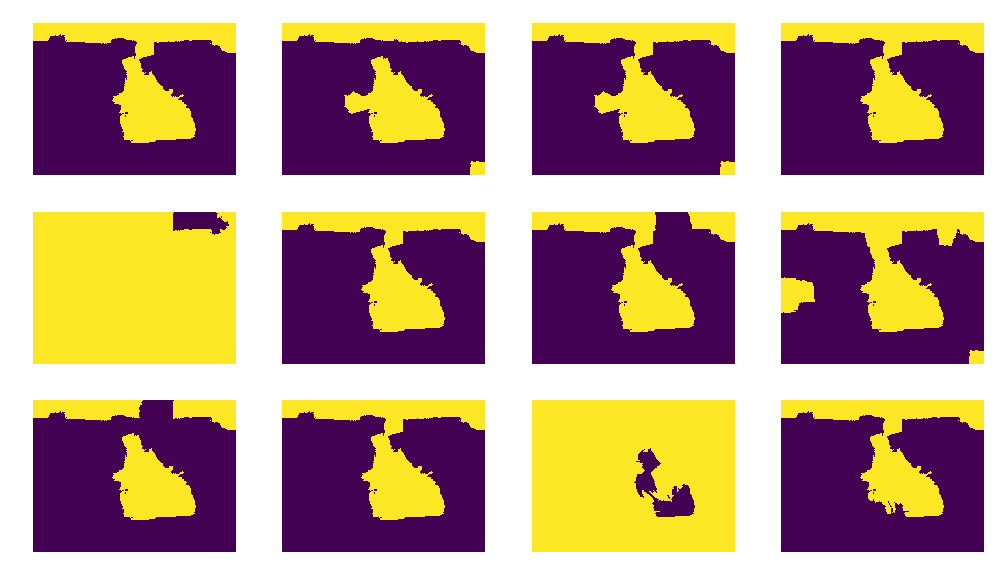

In [615]:
_, axs = plt.subplots(3,4)
for bar, ax in zip(proposals, axs.flat):
    ax.matshow(bar[sps] == 0)
    ax.set_axis_off()
plt.tight_layout();

In [616]:
def merge_proposals(proposals, sps, thresh):
    masks = (proposals[sps] < thresh).astype(int)
    
    base = np.zeros_like(masks[:,:,0])
    for mask in np.rollaxis(masks, 2):
        base = seg.join_segmentations(base, mask)
    return base

/Users/emory/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


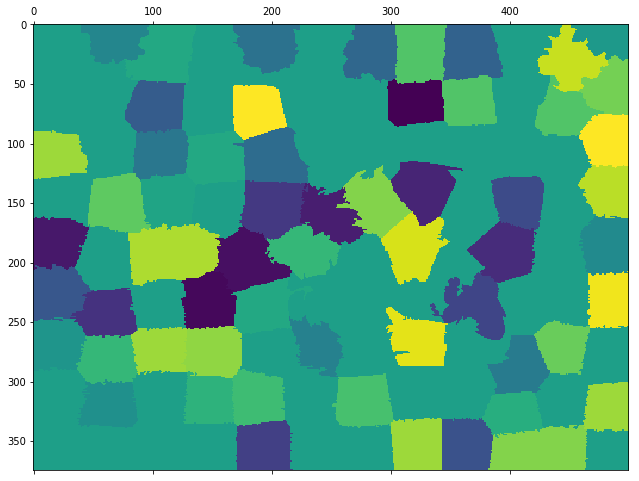

In [617]:
segmentation = merge_proposals(proposals, sps, 1)
plt.matshow(segmentation)